<a href="https://colab.research.google.com/github/asrorKholmatov/ML-Engineer-Portfolio/blob/main/mnist_cnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms

In [2]:
!nvidia-smi

Thu Aug 14 16:51:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
train_data = datasets.MNIST(root="data",
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())

test_data = datasets.MNIST(root="data",
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.47MB/s]


In [5]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

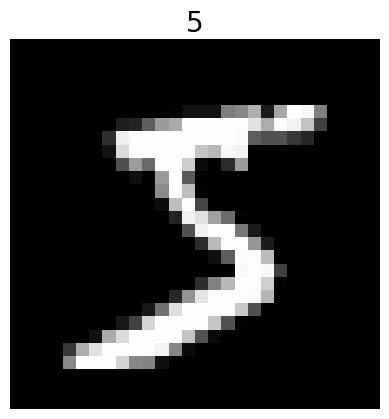

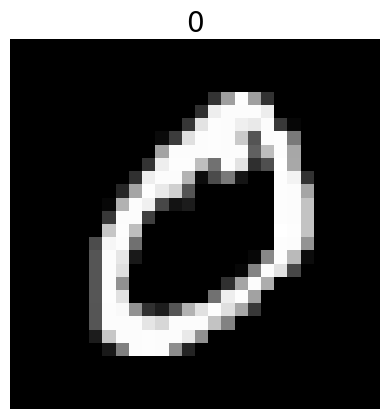

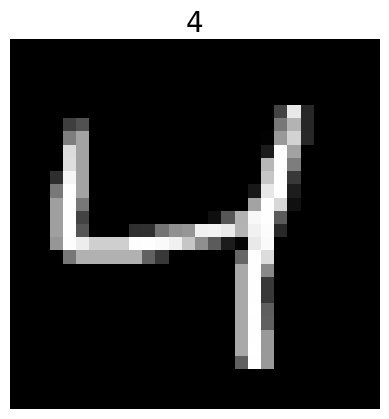

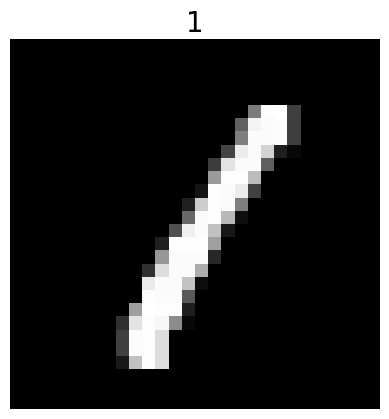

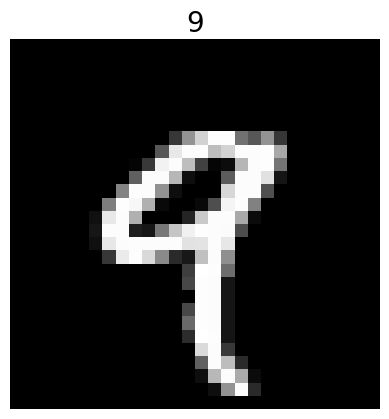

In [7]:
import matplotlib.pyplot as plt
for i in range(5):
  img, label = train_data[i]
  plt.imshow(img.permute(1, 2, 0), cmap="gray")
  plt.title(label, fontsize=20)
  plt.axis(False)
  plt.show()

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(test_data,
                            batch_size=32,
                            shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False)

In [9]:
images, labels = next(iter(train_dataloader))
print(f"images shape: {images.shape}")
print(f"labels shape: {labels.shape}")

images shape: torch.Size([32, 1, 28, 28])
labels shape: torch.Size([32])


In [10]:
class MNIST_model(torch.nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [11]:
model = MNIST_model(input_shape=1,
                    hidden_units=10,
                    output_shape=10).to(device)
model

MNIST_model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [13]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [14]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [15]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = loss_fn,
          epochs: int = 5):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    print(
        f"Epoch: {epoch+1} |"
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

model_1_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.4934 |train_acc: 0.8346 |test_loss: 0.1873 |test_acc: 0.9423
Epoch: 2 |train_loss: 0.1862 |train_acc: 0.9424 |test_loss: 0.1232 |test_acc: 0.9632
Epoch: 3 |train_loss: 0.1359 |train_acc: 0.9539 |test_loss: 0.0892 |test_acc: 0.9714
Epoch: 4 |train_loss: 0.1097 |train_acc: 0.9648 |test_loss: 0.0988 |test_acc: 0.9701
Epoch: 5 |train_loss: 0.0930 |train_acc: 0.9705 |test_loss: 0.0875 |test_acc: 0.9697
Epoch: 6 |train_loss: 0.0916 |train_acc: 0.9689 |test_loss: 0.0634 |test_acc: 0.9787
Epoch: 7 |train_loss: 0.0814 |train_acc: 0.9726 |test_loss: 0.1166 |test_acc: 0.9598
Epoch: 8 |train_loss: 0.0803 |train_acc: 0.9758 |test_loss: 0.0544 |test_acc: 0.9809
Epoch: 9 |train_loss: 0.0753 |train_acc: 0.9752 |test_loss: 0.0823 |test_acc: 0.9732
Epoch: 10 |train_loss: 0.0830 |train_acc: 0.9709 |test_loss: 0.0643 |test_acc: 0.9794


In [17]:
def plot_loss_curves(results):

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

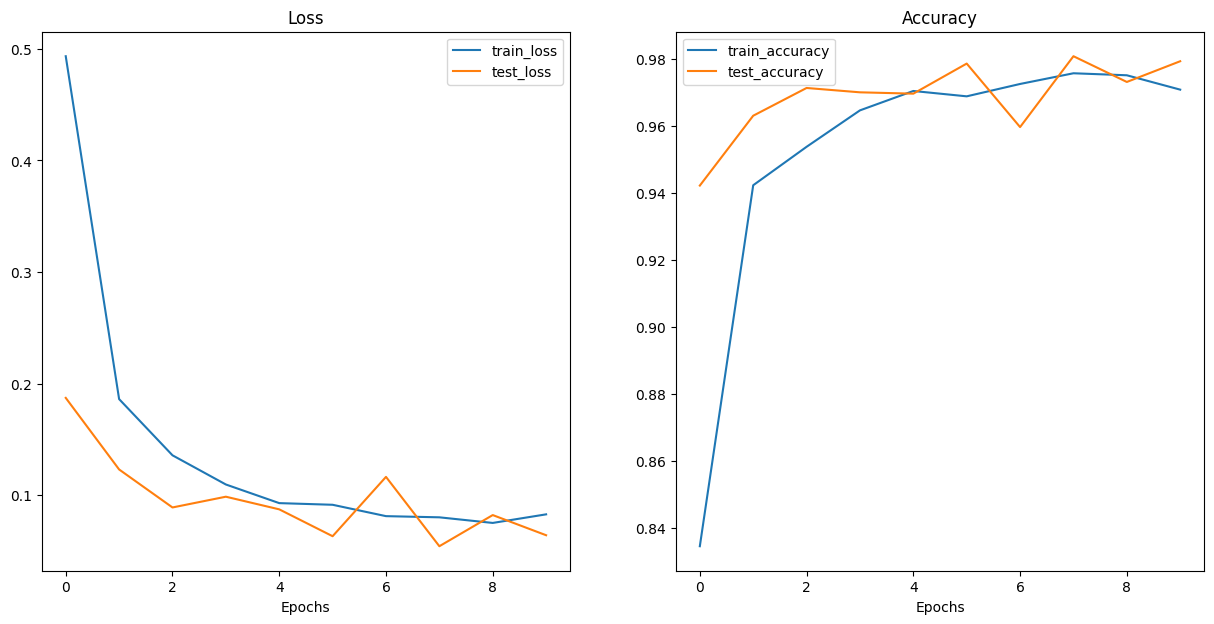

In [18]:
plot_loss_curves(model_1_results)

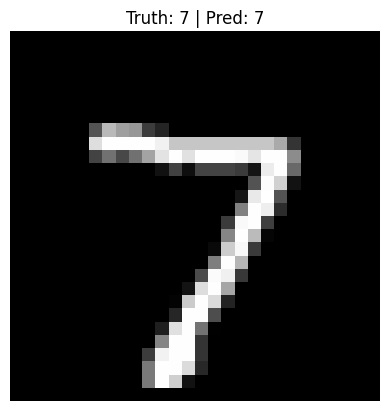

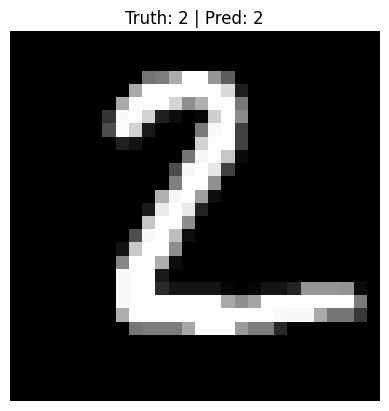

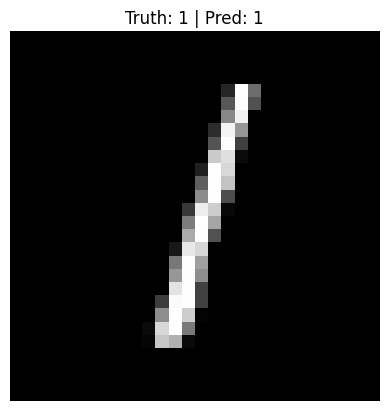

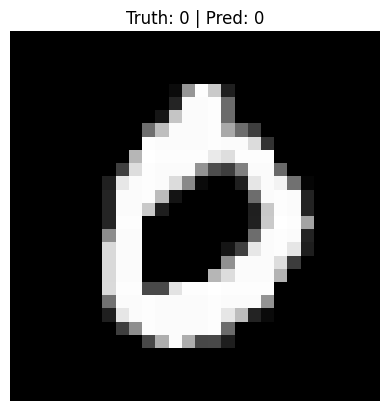

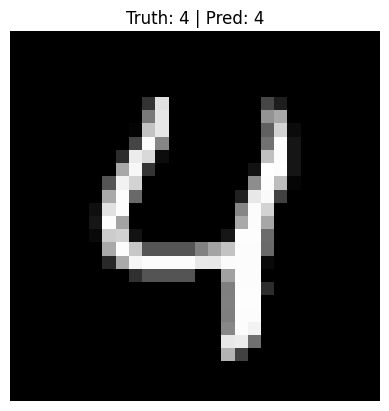

In [19]:
num_to_plot = 5
for i in range(num_to_plot):
  img = test_data[i][0]
  label = test_data[i][1]

  model_pred_logits = model(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(f"Truth: {label} | Pred: {model_pred_label.item()}")
  plt.axis(False)